In [1]:
import warnings
warnings.filterwarnings('ignore')
import stwcs
import glob
import sys
import os
import shutil
import time
import filecmp
import astroquery
import progressbar
import copy
import requests
import random
import astropy.wcs as wcs
import numpy as np
from contextlib import contextmanager
from astropy import units as u
from astropy.utils.data import clear_download_cache,download_file
from astropy.io import fits
from astropy.table import Table, Column, unique
from astropy.time import Time
from astroscrappy import detect_cosmics
from stwcs import updatewcs
from scipy.interpolate import interp1d

# Internal dependencies
from common import Constants
from common import Options
from common import Settings
from common import Util
from nbutils import get_filter, get_instrument, get_chip, get_filter, input_list
from nbutils import get_zpt, add_visit_info, organize_reduction_tables, pick_deepest_images

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

with suppress_stdout():
    from drizzlepac import tweakreg,astrodrizzle,catalogs,photeq
    from astroquery.mast import Observations
    from astropy.coordinates import SkyCoord

In [2]:
acceptable_filters = [
    'F220W','F250W','F330W','F344N','F435W','F475W','F550M','F555W',
    'F606W','F625W','F660N','F660N','F775W','F814W','F850LP','F892N',
    'F098M','F105W','F110W','F125W','F126N','F127M','F128N','F130N','F132N',
    'F139M','F140W','F153M','F160W','F164N','F167N','F200LP','F218W','F225W',
    'F275W','F280N','F300X','F336W','F343N','F350LP','F373N','F390M','F390W',
    'F395N','F410M','F438W','F467M','F469N','F475X','F487N','F547M',
    'F600LP','F621M','F625W','F631N','F645N','F656N','F657N','F658N','F665N',
    'F673N','F680N','F689M','F763M','F845M','F953N','F122M','F160BW','F185W',
    'F218W','F255W','F300W','F375N','F380W','F390N','F437N','F439W','F450W',
    'F569W','F588N','F622W','F631N','F673N','F675W','F702W','F785LP','F791W',
    'F953N','F1042M']

### HST

In [3]:
ra, dec = 31.4625, -58.49072
coord = SkyCoord(ra, dec, frame='icrs', unit='deg')
radius = 5*u.arcmin

In [4]:
obsTable = Observations.query_region(coord, radius=radius)

In [5]:
obsTable = obsTable.filled()

In [6]:
masks = []
masks.append([t.upper()=='HST' for t in obsTable['obs_collection']])
masks.append([p.upper()=='IMAGE' for p in obsTable['dataproduct_type']])
masks.append([any(l) for l in list(map(list,zip(*[[det in inst.upper()
            for inst in obsTable['instrument_name']]
            for det in ['ACS','WFC','WFPC2']])))])
# Added mask to remove calibration data from search
masks.append([f.upper()!='DETECTION' for f in obsTable['filters']])
masks.append([i.upper()!='CALIBRATION' for i in obsTable['intentType']])

In [7]:
mask = [all(l) for l in list(map(list, zip(*masks)))]
obsTable = obsTable[mask]

In [8]:
obsTable.sort('t_min')

In [21]:
obsTable_ = obsTable[obsTable['instrument_name'] == 'WFC3/IR'][:6] #obsTable[5:15]

In [22]:
obsTable_

<Table length=6>
intentType obs_collection provenance_name ...  srcDen  obsid   distance
  str11        str11           str17      ... float64   str9   float64 
---------- -------------- --------------- ... ------- -------- --------
   science            HST          CALWF3 ...     nan 24815204      0.0
   science            HST         HAP-MVM ...     nan 84761045      0.0
   science            HST         HAP-SVM ...     nan 26617779      0.0
   science            HST         HAP-MVM ...     nan 84761053      0.0
   science            HST          CALWF3 ...     nan 24815205      0.0
   science            HST         HAP-MVM ...     nan 84851267      0.0

In [23]:
productlist = None

#### All products for single observation

In [15]:
obs = obsTable_[0]

In [16]:
prlst = Observations.get_product_list(obs)

In [17]:
prlst

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str8,str3,str5,str35,str62,str1,str67,str9,str28,str11,str1,str7,str19,str5,str50,int64,str8,str6,int64,str9
23956103,HST,image,icn105dvq,DADS FLT_HLET,S,mast:HST/product/icn105dvq_flt_hlet.fits,AUXILIARY,--,FLT_HLET,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt_hlet.fits,8640,24815204,PUBLIC,2,F140W
23956103,HST,image,icn105dvq,Preview-Full,S,mast:HST/product/icn105dvq_flt.jpg,PREVIEW,--,--,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.jpg,210263,24815204,PUBLIC,2,F140W
23956103,HST,image,icn105dvq,DADS LOG file,S,mast:HST/product/icn105dvq_log.txt,INFO,--,LOG,--,CALWF3,--,13677,icn105dvq_log.txt,7348,24815204,PUBLIC,1,F140W
23956103,HST,image,icn105dvq,DADS SPT file - Engineering telemetry ACS/WFC3/NICMOS/COS/STIS,S,mast:HST/product/icn105dvq_spt.fits,AUXILIARY,--,SPT,--,CALWF3,--,13677,icn105dvq_spt.fits,852480,24815204,PUBLIC,1,F140W
23956103,HST,image,icn105dvq,Preview-Full,S,mast:HST/product/icn105dvq_raw.jpg,PREVIEW,--,--,--,CALWF3,--,13677,icn105dvq_raw.jpg,248097,24815204,PUBLIC,1,F140W
23956103,HST,image,icn105dvq,DADS TRL file - Processing log,S,mast:HST/product/icn105dvq_trl.fits,AUXILIARY,--,TRL,--,CALWF3,--,13677,icn105dvq_trl.fits,25920,24815204,PUBLIC,1,F140W
23956103,HST,image,icn105dvq,DADS IMA file - Intermediate Mult-Accum WFC3/NICMOS,S,mast:HST/product/icn105dvq_ima.fits,AUXILIARY,--,IMA,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_ima.fits,115686720,24815204,PUBLIC,2,F140W
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,24815204,PUBLIC,2,F140W
23956103,HST,image,icn105dvq,DADS RAW file - Raw exposure COS/NICMOS/STIS/WFC3/ACS,S,mast:HST/product/icn105dvq_raw.fits,SCIENCE,--,RAW,--,CALWF3,--,13677,icn105dvq_raw.fits,23400000,24815204,PUBLIC,1,F140W


In [18]:
splt = [prod.split('_')[-1] for prod in prlst['productFilename']]

In [19]:
np.unique(np.array(splt))

array(['asn.fits', 'color.jpg', 'drz.fits', 'drz.jpg', 'flt.fits',
       'flt.jpg', 'hlet.fits', 'ima.fits', 'jif.fits', 'jit.fits',
       'log.txt', 'point-cat.ecsv', 'raw.fits', 'raw.jpg',
       'segment-cat.ecsv', 'spt.fits', 'trl.fits', 'trl.txt'],
      dtype='<U16')

In [20]:
pmask = [('drz.fits' in prod) | ('drc.fits' in prod) | ('flt.fits' in prod) for prod in prlst['productFilename']]

In [21]:
prlst[pmask]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str8,str3,str5,str35,str62,str1,str67,str9,str28,str11,str1,str7,str19,str5,str50,int64,str8,str6,int64,str9
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,24815204,PUBLIC,2,F140W
23956104,HST,image,icn105dwq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dwq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dwq_flt.fits,16634880,24815204,PUBLIC,2,F140W
24815204,HST,image,icn105010,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/icn105010_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105010_drz.fits,13311360,24815204,PUBLIC,3,F140W
26617076,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dv,HAP flat-field product,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dv_flt.fits,SCIENCE,--,FLT,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dv_flt.fits,16646400,24815204,PUBLIC,2,F140W
26617076,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dv,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dv_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dv_drz.fits,23279040,24815204,PUBLIC,2,F140W
26617135,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dw,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dw_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dw_drz.fits,23279040,24815204,PUBLIC,2,F140W
26617135,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dw,HAP flat-field product,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dw_flt.fits,SCIENCE,--,FLT,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dw_flt.fits,16646400,24815204,PUBLIC,2,F140W
26617277,HST,image,hst_13677_05_wfc3_ir_total_icn105,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_total_icn105_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_total_icn105_drz.fits,23302080,24815204,PUBLIC,3,detection
26617779,HST,image,hst_13677_05_wfc3_ir_f140w_icn105,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105_drz.fits,23284800,24815204,PUBLIC,3,F140W


In [22]:
productlist = prlst[pmask]

In [23]:
downloadFilenames = []
for prod in productlist:
    filename = prod['productFilename']

    # Cut down new HST filenames that start with hst_PROGID
    filename = '_'.join(filename.split('_')[-2:])
    downloadFilenames.append(filename)

productlist.add_column(Column(downloadFilenames, name='downloadFilename'))

# Check that all files to download are unique
if productlist and len(productlist)>1:
    productlist = unique(productlist, keys='downloadFilename')

# Sort by obsID in case we need to reference
productlist.sort('obsID')

In [24]:
productlist

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters,downloadFilename
str8,str3,str5,str35,str62,str1,str67,str9,str28,str11,str1,str7,str19,str5,str50,int64,str8,str6,int64,str9,str18
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,24815204,PUBLIC,2,F140W,icn105dvq_flt.fits
23956104,HST,image,icn105dwq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dwq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dwq_flt.fits,16634880,24815204,PUBLIC,2,F140W,icn105dwq_flt.fits
24815204,HST,image,icn105010,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/icn105010_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105010_drz.fits,13311360,24815204,PUBLIC,3,F140W,icn105010_drz.fits
26617076,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dv,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dv_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dv_drz.fits,23279040,24815204,PUBLIC,2,F140W,icn105dv_drz.fits
26617076,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dv,HAP flat-field product,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dv_flt.fits,SCIENCE,--,FLT,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dv_flt.fits,16646400,24815204,PUBLIC,2,F140W,icn105dv_flt.fits
26617135,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dw,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dw_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dw_drz.fits,23279040,24815204,PUBLIC,2,F140W,icn105dw_drz.fits
26617135,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dw,HAP flat-field product,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dw_flt.fits,SCIENCE,--,FLT,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dw_flt.fits,16646400,24815204,PUBLIC,2,F140W,icn105dw_flt.fits
26617277,HST,image,hst_13677_05_wfc3_ir_total_icn105,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_total_icn105_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_total_icn105_drz.fits,23302080,24815204,PUBLIC,3,detection,icn105_drz.fits


#### general productlist for all observations

In [19]:
obs = obsTable_

In [24]:
for i, obs in enumerate(obsTable_):
    try:
        productList = Observations.get_product_list(obs)
        # Ignore the 'C' type products
        mask = productList['type']=='S'
        productList = productList[mask]
    except:
        error = 'ERROR: MAST is not working currently working\n'
        error += 'Try again later...'
        print(error)
    #         return(productlist)

    instrument = obs['instrument_name']
    s_ra = obs['s_ra']
    s_dec = obs['s_dec']

    instcol = Column([instrument]*len(productList), name='instrument_name')
    racol = Column([s_ra]*len(productList), name='ra')
    deccol = Column([s_dec]*len(productList), name='dec')

    productList.add_column(instcol)
    productList.add_column(racol)
    productList.add_column(deccol)

    for prod in productList:
        filename = prod['productFilename']

        if (('c0m.fits' in filename and 'WFPC2' in instrument) or
            ('c1m.fits' in filename and 'WFPC2' in instrument) or
            ('c0m.fits' in filename and 'PC/WFC' in instrument) or
            ('c1m.fits' in filename and 'PC/WFC' in instrument) or
            ('flc.fits' in filename and 'ACS/WFC' in instrument) or
            ('flt.fits' in filename and 'ACS/HRC' in instrument) or
            ('flc.fits' in filename and 'WFC3/UVIS' in instrument) or
            ('flt.fits' in filename and 'WFC3/IR' in instrument)):

            if not productlist:
                productlist = Table(prod)
            else:
                productlist.add_row(prod)

In [25]:
productlist

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters,instrument_name,ra,dec
str8,str3,str5,str35,str62,str1,str67,str9,str28,str11,str1,str7,str19,str5,str50,int64,str8,str6,int64,str9,str7,float64,float64
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,24815204,PUBLIC,2,F140W,WFC3/IR,31.44337834647,-58.48585330631
23956104,HST,image,icn105dwq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dwq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dwq_flt.fits,16634880,24815204,PUBLIC,2,F140W,WFC3/IR,31.44337834647,-58.48585330631
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,26617779,PUBLIC,2,F140W,WFC3/IR,31.4428,-58.4852
23956104,HST,image,icn105dwq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dwq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dwq_flt.fits,16634880,26617779,PUBLIC,2,F140W,WFC3/IR,31.4428,-58.4852
23956105,HST,image,icn105dyq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dyq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dyq_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631
23956106,HST,image,icn105e0q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e0q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e0q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631
23956107,HST,image,icn105e2q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e2q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e2q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631
23956108,HST,image,icn105e3q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e3q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e3q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631


In [26]:
downloadFilenames = []
for prod in productlist:
    filename = prod['productFilename']

    # Cut down new HST filenames that start with hst_PROGID
    filename = '_'.join(filename.split('_')[-2:])
    downloadFilenames.append(filename)

productlist.add_column(Column(downloadFilenames, name='downloadFilename'))

# Check that all files to download are unique
if productlist and len(productlist)>1:
    productlist = unique(productlist, keys='downloadFilename')

# Sort by obsID in case we need to reference
productlist.sort('obsID')

In [27]:
productlist

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters,instrument_name,ra,dec,downloadFilename
str8,str3,str5,str35,str62,str1,str67,str9,str28,str11,str1,str7,str19,str5,str50,int64,str8,str6,int64,str9,str7,float64,float64,str18
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,24815204,PUBLIC,2,F140W,WFC3/IR,31.44337834647,-58.48585330631,icn105dvq_flt.fits
23956104,HST,image,icn105dwq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dwq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dwq_flt.fits,16634880,24815204,PUBLIC,2,F140W,WFC3/IR,31.44337834647,-58.48585330631,icn105dwq_flt.fits
23956105,HST,image,icn105dyq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dyq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dyq_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631,icn105dyq_flt.fits
23956106,HST,image,icn105e0q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e0q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e0q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631,icn105e0q_flt.fits
23956107,HST,image,icn105e2q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e2q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e2q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631,icn105e2q_flt.fits
23956108,HST,image,icn105e3q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e3q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e3q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631,icn105e3q_flt.fits


In [28]:
Observations.download_products(productlist, extension='fits')

Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/icn105dvq/icn105dvq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icn105dwq/icn105dwq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icn105dyq/icn105dyq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icn105e0q/icn105e0q_flt.fits,COMPLETE,None,None
./mastDownload/HST/icn105e2q/icn105e2q_flt.fits,COMPLETE,None,None
./mastDownload/HST/icn105e3q/icn105e3q_flt.fits,COMPLETE,None,None


In [31]:
workdir = '.'
input_images = [s for p in ['*flc.fits', '*flt.fits'] for s in glob.glob(os.path.join(workdir, p))]

In [32]:
input_images

['./icn105dvq_flt.fits',
 './icn105dyq_flt.fits',
 './icn105dwq_flt.fits',
 './icn105e3q_flt.fits',
 './icn105e2q_flt.fits',
 './icn105e0q_flt.fits']

In [35]:
img = input_images
zptype = 'abmag'
good = []
image_number = []
#check if image exists (check in archive otherwise)
for image in img:
    success = True
    if not os.path.exists(image):
        success = False
    if success:
        good.append(image)
img = copy.copy(good)

hdu = fits.open(img[0])
h = hdu[0].header

exp = [fits.getval(image,'EXPTIME') for image in img] #exposure time
if 'DATE-OBS' in h.keys() and 'TIME-OBS' in h.keys(): 
    dat = [fits.getval(image,'DATE-OBS') + 'T' +
           fits.getval(image,'TIME-OBS') for image in img] #datetime
elif 'EXPSTART' in h.keys():
    dat = [Time(fits.getval(image, 'EXPSTART'),
        format='mjd').datetime.strftime('%Y-%m-%dT%H:%M:%S') #datetime if DATE-OBS is missing
        for image in img]
    
fil = [get_filter(image) for image in img]
ins = [get_instrument(image) for image in img]
det = ['_'.join(get_instrument(image).split('_')[:2]) for image in img]
chip= [get_chip(image) for image in img]
zpt = [get_zpt(i, ccdchip=c, zptype=zptype) for i,c in zip(img,chip)]

if not image_number:
    image_number = [0 for image in img]
    
obstable = Table([img,exp,dat,fil,ins,det,zpt,chip,image_number],
    names=['image','exptime','datetime','filter','instrument',
     'detector','zeropoint','chip','imagenumber'])
obstable.sort('datetime')
obstable = add_visit_info(obstable)

In [36]:
obstable.add_column(Column([' '*99]*len(obstable), name='drizname'))
for i,row in enumerate(obstable):
    visit = row['visit']
    n = str(visit).zfill(4)
    inst = row['instrument']
    filt = row['filter']

    # Visit should correspond to first image so they're all the same
    visittable = obstable[obstable['visit']==visit]
    refimage = visittable['image'][0]
    if 'DATE-OBS' in h.keys():
        date_obj = Time(fits.getval(refimage, 'DATE-OBS'))
    else:
        date_obj = Time(fits.getval(refimage, 'EXPSTART'), format='mjd')
    date_str = date_obj.datetime.strftime('%y%m%d')

    # Make a photpipe-like image name
    drizname = ''
    objname = None
    if objname:
        drizname = '{obj}.{inst}.{filt}.ut{date}_{n}.drz.fits'
        drizname = drizname.format(inst=inst.split('_')[0],
            filt=filt, n=n, date=date_str, obj=objname)
    else:
        drizname = '{inst}.{filt}.ut{date}_{n}.drz.fits'
        drizname = drizname.format(inst=inst.split('_')[0],
            filt=filt, n=n, date=date_str)

    if '.':
        drizname = os.path.join('.', drizname)

    obstable[i]['drizname'] = drizname

In [37]:
obstable

image,exptime,datetime,filter,instrument,detector,zeropoint,chip,imagenumber,visit,drizname
str20,float64,str19,str5,str12,str7,float64,str2,int64,int64,str99
./icn105dvq_flt.fits,452.936035,2014-10-06T14:22:18,f140w,wfc3_ir_full,wfc3_ir,26.45070798348457,IR,0,1,./wfc3.f140w.ut141006_0001.drz.fits
./icn105dwq_flt.fits,452.936035,2014-10-06T14:31:00,f140w,wfc3_ir_full,wfc3_ir,26.45070798348457,IR,0,1,./wfc3.f140w.ut141006_0001.drz.fits
./icn105dyq_flt.fits,252.934357,2014-10-06T14:39:42,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits
./icn105e0q_flt.fits,252.934357,2014-10-06T14:44:57,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits
./icn105e2q_flt.fits,252.934357,2014-10-06T15:35:50,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits
./icn105e3q_flt.fits,252.934357,2014-10-06T15:41:05,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits


In [38]:
table = organize_reduction_tables(obstable, byvisit = True)

In [39]:
table

[<Table length=2>
        image          exptime   ... visit               drizname             
        str20          float64   ... int64                str99               
 -------------------- ---------- ... ----- -----------------------------------
 ./icn105dvq_flt.fits 452.936035 ...     1 ./wfc3.f140w.ut141006_0001.drz.fits
 ./icn105dwq_flt.fits 452.936035 ...     1 ./wfc3.f140w.ut141006_0001.drz.fits,
 <Table length=4>
        image          exptime   ... visit               drizname             
        str20          float64   ... int64                str99               
 -------------------- ---------- ... ----- -----------------------------------
 ./icn105dyq_flt.fits 252.934357 ...     2 ./wfc3.f105w.ut141006_0002.drz.fits
 ./icn105e0q_flt.fits 252.934357 ...     2 ./wfc3.f105w.ut141006_0002.drz.fits
 ./icn105e2q_flt.fits 252.934357 ...     2 ./wfc3.f105w.ut141006_0002.drz.fits
 ./icn105e3q_flt.fits 252.934357 ...     2 ./wfc3.f105w.ut141006_0002.drz.fits]

### JWST

In [3]:
#288.26458333, 19.77305556 BOAT

#images for M92
# ra, dec = 259.2800254, 43.13566 
#images for NGC0628
# ra, dec = 24.174049, 15.78346
#images for SN2024aecx
ra, dec = 166.4564675, -0.034845
#long wavelength image for gaia test
# ra, dec = 288.180264431434, -2.33687287711816
coord = SkyCoord(ra, dec, frame='icrs', unit='deg')
radius = 5*u.arcmin

In [4]:
obsTable = Observations.query_region(coord, radius=radius)

In [5]:
obsTable = obsTable.filled()

In [6]:
#obsTable masks
masks = []
masks.append([t.upper()=='JWST' for t in obsTable['obs_collection']]) #JWST images
masks.append([any(l) for l in list(map(list,zip(*[[det in inst.upper() #NIRCAM images
            for inst in obsTable['instrument_name']]
            for det in ['NIRCAM']])))])

#add mask to remove entries with 1. null jpegURL/dataURL 2. private data rights(?)
# Added mask to remove calibration data from separch
masks.append([f.upper()!='DETECTION' for f in obsTable['filters']])
masks.append([i.upper()!='CALIBRATION' for i in obsTable['intentType']])

mask = [all(l) for l in list(map(list, zip(*masks)))]
obsTable_webb = obsTable[mask]

In [7]:
obsTable_webb

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str11,str11,str12,str12,str4,str26,str16,str40,str38,str53,float64,float64,str10,str21,int64,float64,float64,float64,float64,float64,str106,float64,str17,str12,int64,str3979,str137,str138,str6,bool,float64,str9,float64
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F150W,INFRARED,NGC3521,Galaxy; Spiral galaxies,jw03707-o046_t026_nircam_clear-f150w,166.45239,-0.03595000000001391,image,"Leroy, Adam",3,60430.10237971505,60430.10797271991,214.736,1331.0,1668.0,A JWST Census of the Local Galaxy Population: Anchoring the Physics of the Matter Cycle,60430.14903934,3707,GO,999999,POLYGON 166.441705094 -0.010638087 166.478327709 -0.02278161 166.466125056 -0.059582556 166.429502429 -0.047439028,mast:JWST/product/jw03707-o046_t026_nircam_clear-f150w_i2d.jpg,mast:JWST/product/jw03707-o046_t026_nircam_clear-f150w_i2d.fits,PUBLIC,False,nan,214056304,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F187N,INFRARED,NGC3521,Galaxy; Spiral galaxies,jw03707-o046_t026_nircam_clear-f187n,166.45239,-0.03595000000001391,image,"Leroy, Adam",3,60430.111451519675,60430.11903270833,386.524,1863.0,1884.0,A JWST Census of the Local Galaxy Population: Anchoring the Physics of the Matter Cycle,60430.14903934,3707,GO,999999,POLYGON 166.441704244 -0.010646156 166.478325785 -0.022789355 166.466126146 -0.059581116 166.429504592 -0.047437912,mast:JWST/product/jw03707-o046_t026_nircam_clear-f187n_i2d.jpg,mast:JWST/product/jw03707-o046_t026_nircam_clear-f187n_i2d.fits,PUBLIC,False,nan,214056308,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F300M,INFRARED,NGC3521,Galaxy; Spiral galaxies,jw03707-o046_t026_nircam_clear-f300m,166.45239,-0.03595000000001391,image,"Leroy, Adam",3,60430.102380455784,60430.10797271991,214.736,2829.0,3155.0,A JWST Census of the Local Galaxy Population: Anchoring the Physics of the Matter Cycle,60430.14903934,3707,GO,999999,POLYGON 166.441907785 -0.010855432 166.477966722 -0.022587815 166.466196442 -0.058763231 166.430137494 -0.047030844,mast:JWST/product/jw03707-o046_t026_nircam_clear-f300m_i2d.jpg,mast:JWST/product/jw03707-o046_t026_nircam_clear-f300m_i2d.fits,PUBLIC,False,nan,214037495,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F335M,INFRARED,NGC3521,Galaxy; Spiral galaxies,jw03707-o046_t026_nircam_clear-f335m,166.45239,-0.03595000000001391,image,"Leroy, Adam",3,60430.11145226042,60430.11903270833,386.524,3177.0,3538.0,A JWST Census of the Local Galaxy Population: Anchoring the Physics of the Matter Cycle,60430.14903934,3707,GO,999999,POLYGON 166.441902886 -0.010856259 166.477962693 -0.022588957 166.466192098 -0.058765248 166.430132278 -0.047032545,mast:JWST/product/jw03707-o046_t026_nircam_clear-f335m_i2d.jpg,mast:JWST/product/jw03707-o046_t026_nircam_clear-f335m_i2d.fits,PUBLIC,False,nan,214056313,0.0


In [35]:
obsTable_webb['s_region'][0]

'POLYGON 166.441705094 -0.010638087 166.478327709 -0.02278161 166.466125056 -0.059582556 166.429502429 -0.047439028'

In [36]:
import shapely

In [37]:
pgons, filt = [], []
for i in range(len(obsTable_webb)):
    region = obsTable_webb['s_region'][i]
    coords = np.array(region.split('POLYGON ')[1].split(' '), dtype = float)
    pgons.append(shapely.Polygon(coords.reshape(4, 2)))
    filt.append(obsTable_webb['filters'][i])

In [16]:
np.unique(np.array(filt))

array(['F150W', 'F187N', 'F300M', 'F335M'], dtype='<U5')

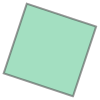

In [17]:
net_field = shapely.unary_union(pgons)
net_field

In [29]:
f277_obs = np.array(pgons)[np.array(filt) == 'F150W']

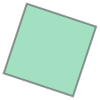

In [30]:
f277_field = shapely.unary_union(f277_obs)
f277_field

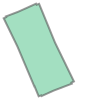

In [43]:
net_field

In [44]:
shapely.intersection(f277_field, net_field).area/f277_field.area

0.9999999999999784

In [8]:
productList_0 = Observations.get_product_list(obsTable_webb[0])

In [9]:
productList_0

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str5,str36,str64,str1,str68,str9,str28,str11,str1,str7,str6,str4,str50,int64,str9,str6,int64,str5
214010675,JWST,image,jw03707046001_02101_00001_nrcb1,FGS1 guide star acquisition,S,mast:JWST/product/jw03707046001_gs-acq1_2024121022223_stream.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,3707,jw03707046001_gs-acq1_2024121022223_stream.fits,408960,214056304,PUBLIC,1,F150W
214010675,JWST,image,jw03707046001_02101_00001_nrcb1,FGS1 guide star acquisition,S,mast:JWST/product/jw03707046001_gs-acq1_2024121022223_uncal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,3707,jw03707046001_gs-acq1_2024121022223_uncal.fits,420480,214056304,PUBLIC,1,F150W
214010675,JWST,image,jw03707046001_02101_00001_nrcb1,FGS1 guide star acquisition,S,mast:JWST/product/jw03707046001_gs-acq1_2024121022310_stream.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,3707,jw03707046001_gs-acq1_2024121022310_stream.fits,408960,214056304,PUBLIC,1,F150W
214010675,JWST,image,jw03707046001_02101_00001_nrcb1,FGS1 guide star acquisition,S,mast:JWST/product/jw03707046001_gs-acq1_2024121022310_uncal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,3707,jw03707046001_gs-acq1_2024121022310_uncal.fits,420480,214056304,PUBLIC,1,F150W
214010675,JWST,image,jw03707046001_02101_00001_nrcb1,FGS1 guide star acquisition,S,mast:JWST/product/jw03707046001_gs-acq1_2024121022223_cal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,1.15.1,3707,jw03707046001_gs-acq1_2024121022223_cal.fits,1284480,214056304,PUBLIC,2,F150W
214010675,JWST,image,jw03707046001_02101_00001_nrcb1,FGS1 guide star acquisition,S,mast:JWST/product/jw03707046001_gs-acq1_2024121022310_cal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,1.15.1,3707,jw03707046001_gs-acq1_2024121022310_cal.fits,1284480,214056304,PUBLIC,2,F150W
214010675,JWST,image,jw03707046001_02101_00001_nrcb1,FGS2 guide star acquisition,S,mast:JWST/product/jw03707046001_gs-acq2_2024121022225_stream.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,3707,jw03707046001_gs-acq2_2024121022225_stream.fits,37440,214056304,PUBLIC,1,F150W
214010675,JWST,image,jw03707046001_02101_00001_nrcb1,FGS2 guide star acquisition,S,mast:JWST/product/jw03707046001_gs-acq2_2024121022225_uncal.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,3707,jw03707046001_gs-acq2_2024121022225_uncal.fits,48960,214056304,PUBLIC,1,F150W
214010675,JWST,image,jw03707046001_02101_00001_nrcb1,FGS2 guide star acquisition,S,mast:JWST/product/jw03707046001_gs-acq2_2024121022312_stream.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,3707,jw03707046001_gs-acq2_2024121022312_stream.fits,37440,214056304,PUBLIC,1,F150W


In [10]:
productList = productList_0
stage = 2

In [11]:
#product list masks
productmasks = []
productmasks.append([p.upper() == 'SCIENCE' for p in productList['productType']])
if stage == 2:
    productmasks.append([t == 'CAL' for t in productList['productSubGroupDescription']])
    productmasks.append([c == 2 for c in productList['calib_level']])
if stage == 3:
    productmasks.append([t == 'I2D' for t in productList['productSubGroupDescription']])
    productmasks.append([c == 3 for c in productList['calib_level']])


productmask = [all(l) for l in list(map(list, zip(*productmasks)))]
productList = productList[productmask]

In [12]:
productList

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str5,str36,str64,str1,str68,str9,str28,str11,str1,str7,str6,str4,str50,int64,str9,str6,int64,str5
214010675,JWST,image,jw03707046001_02101_00001_nrcb1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw03707046001_02101_00001_nrcb1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,3707,jw03707046001_02101_00001_nrcb1_cal.fits,117544320,214056304,PUBLIC,2,F150W
214010688,JWST,image,jw03707046001_02101_00003_nrcb2,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw03707046001_02101_00003_nrcb2_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,3707,jw03707046001_02101_00003_nrcb2_cal.fits,117544320,214056304,PUBLIC,2,F150W
214010689,JWST,image,jw03707046001_02101_00004_nrcb4,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw03707046001_02101_00004_nrcb4_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,3707,jw03707046001_02101_00004_nrcb4_cal.fits,117544320,214056304,PUBLIC,2,F150W
214031062,JWST,image,jw03707046001_02101_00003_nrcb1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw03707046001_02101_00003_nrcb1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,3707,jw03707046001_02101_00003_nrcb1_cal.fits,117544320,214056304,PUBLIC,2,F150W
214031083,JWST,image,jw03707046001_02101_00004_nrcb1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw03707046001_02101_00004_nrcb1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,3707,jw03707046001_02101_00004_nrcb1_cal.fits,117544320,214056304,PUBLIC,2,F150W
214031103,JWST,image,jw03707046001_02101_00003_nrcb3,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw03707046001_02101_00003_nrcb3_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,3707,jw03707046001_02101_00003_nrcb3_cal.fits,117544320,214056304,PUBLIC,2,F150W
214031111,JWST,image,jw03707046001_02101_00004_nrcb3,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw03707046001_02101_00004_nrcb3_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,3707,jw03707046001_02101_00004_nrcb3_cal.fits,117544320,214056304,PUBLIC,2,F150W
214031153,JWST,image,jw03707046001_02101_00002_nrcb1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw03707046001_02101_00002_nrcb1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,3707,jw03707046001_02101_00002_nrcb1_cal.fits,117544320,214056304,PUBLIC,2,F150W
214031168,JWST,image,jw03707046001_02101_00001_nrcb3,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw03707046001_02101_00001_nrcb3_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,3707,jw03707046001_02101_00001_nrcb3_cal.fits,117544320,214056304,PUBLIC,2,F150W


In [29]:
mask = ['nrcalong' in x for x in productList['obs_id']]
productList[mask]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str8,str4,str5,str36,str64,str1,str69,str9,str28,str11,str1,str7,str6,str4,str51,int64,str8,str6,int64,str5
87766476,JWST,image,jw01783004005_02101_00001_nrcalong,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw01783004005_02101_00001_nrcalong_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,1783,jw01783004005_02101_00001_nrcalong_cal.fits,117544320,87767068,PUBLIC,2,F277W
87766478,JWST,image,jw01783004005_02101_00004_nrcalong,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw01783004005_02101_00004_nrcalong_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,1783,jw01783004005_02101_00004_nrcalong_cal.fits,117544320,87767068,PUBLIC,2,F277W
87766489,JWST,image,jw01783004005_02101_00003_nrcalong,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw01783004005_02101_00003_nrcalong_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,1783,jw01783004005_02101_00003_nrcalong_cal.fits,117544320,87767068,PUBLIC,2,F277W
87766503,JWST,image,jw01783004005_02101_00002_nrcalong,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw01783004005_02101_00002_nrcalong_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,1783,jw01783004005_02101_00002_nrcalong_cal.fits,117544320,87767068,PUBLIC,2,F277W
87766624,JWST,image,jw01783004006_02101_00002_nrcalong,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw01783004006_02101_00002_nrcalong_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,1783,jw01783004006_02101_00002_nrcalong_cal.fits,117544320,87767068,PUBLIC,2,F277W
87766626,JWST,image,jw01783004006_02101_00003_nrcalong,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw01783004006_02101_00003_nrcalong_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,1783,jw01783004006_02101_00003_nrcalong_cal.fits,117544320,87767068,PUBLIC,2,F277W
87766640,JWST,image,jw01783004006_02101_00001_nrcalong,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw01783004006_02101_00001_nrcalong_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,1783,jw01783004006_02101_00001_nrcalong_cal.fits,117544320,87767068,PUBLIC,2,F277W
87766660,JWST,image,jw01783004006_02101_00004_nrcalong,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw01783004006_02101_00004_nrcalong_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.15.1,1783,jw01783004006_02101_00004_nrcalong_cal.fits,117544320,87767068,PUBLIC,2,F277W


In [18]:
Observations.download_products(productList, extension='fits')

Local Path,Status,Message,URL
str98,str8,object,object
./mastDownload/JWST/jw01783908001_03101_00001_mirimage/jw01783908001_03101_00001_mirimage_cal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01783908001_03101_00002_mirimage/jw01783908001_03101_00002_mirimage_cal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01783908001_03101_00003_mirimage/jw01783908001_03101_00003_mirimage_cal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01783908001_03101_00004_mirimage/jw01783908001_03101_00004_mirimage_cal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01783908002_02101_00001_mirimage/jw01783908002_02101_00001_mirimage_cal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01783908002_02101_00002_mirimage/jw01783908002_02101_00002_mirimage_cal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01783908002_02101_00003_mirimage/jw01783908002_02101_00003_mirimage_cal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01783908002_02101_00004_mirimage/jw01783908002_02101_00004_mirimage_cal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01783908003_02101_00001_mirimage/jw01783908003_02101_00001_mirimage_cal.fits,COMPLETE,None,None


#### Misc

In [ ]:
def needs_to_be_reduced(self, image, save_c1m=False):

    keep_short = self.options['args'].keep_short
    keep_tdf_down = self.options['args'].keep_tdf_down
    keep_indt = self.options['args'].keep_indt

    #same for jwst
    if not os.path.exists(image):
        success = self.try_to_get_image(image)
        if not success:
            warning = 'WARNING: {image} does not exist'
            return(warning.format(img=image), False)

    #same for jwst
    try:
        hdu = fits.open(image, mode='readonly')
        check = False
        for h in hdu:
            if h.data is not None and h.name.upper()=='SCI':
                check = True
    except (OSError, TypeError, AttributeError):
        warning = 'WARNING: {img} is empty or corrupted.  '
        warning += 'Trying to download again...'
        print(warning.format(img=image))

        success = False
        if not self.productlist:
            warning = 'WARNING: could not find or download {img}'
            return(warning.format(img=image), False)

        mask = self.productlist['productFilename']==image
        if self.productlist[mask]==0: #len?
            warning = 'WARNING: could not find or download {img}'
            return(warning.format(img=image), False)

        self.download_files(self.productlist,
            archivedir=self.options['args'].archive, 
            clobber=True)

        for product in self.productlist[mask]:
            self.copy_raw_data_archive(product, 
                archivedir=self.options['args'].archive,
                workdir=self.options['args'].work_dir, 
                check_for_coord=True)

        if os.path.exists(image):
            try:
                hdu = fits.open(image, mode='readonly')
                check = False
                for h in hdu:
                    if h.data is not None and h.name.upper()=='SCI':
                        check = True
            except (OSError, TypeError, AttributeError):
                warning = 'WARNING: could not find or download {img}'
                return(warning.format(img=image), False)

    is_not_hst_image = False
    warning = ''
    detector = ''

    # Check for header keys that we need
    for key in ['INSTRUME','EXPTIME','DATE-OBS','TIME-OBS']:
        if key not in hdu[0].header.keys():
            warning = 'WARNINGS: {key} not in {img} header'
            warning = warning.format(key=key, img=image)
            return(warning, False)

    instrument = hdu[0].header['INSTRUME'].lower()
    if 'c1m.fits' in image and not save_c1m: # not needed for jwst
        # We need the c1m.fits files, but they aren't reduced as science data
        warning = 'WARNING: do not need to reduce c1m.fits files.'
        return(warning, False)

    if ('DETECTOR' in hdu[0].header.keys()):
        detector = hdu[0].header['DETECTOR'].lower()

    #check expflag for jwst
    # Check for EXPFLAG=='INDETERMINATE', usually indicating a bad exposure
    if 'EXPFLAG' in hdu[0].header.keys():
        flag = hdu[0].header['EXPFLAG']
        if flag=='INDETERMINATE':
            if not keep_indt:
                warning = f'WARNING: {image} has EXPFLAG==INDETERMINATE'
                return(warning, False)
        elif 'TDF-DOWN' in flag:
            if not keep_tdf_down:
                warning = f'WARNING: {image} has EXPFLAG==TDF-DOWN AT EXPSTART'
                return(warning, False)
        elif flag!='NORMAL':
            warning = f'WARNING: {image} has EXPFLAG=={flag}.'
            return(warning, False)

    # Get rid of exposures with exptime < 20s
    if not keep_short:
        exptime = hdu[0].header['EXPTIME']
        if (exptime < 15):
            warning = f'WARNING: {image} EXPTIME is {exptime} < 20.'
            return(warning, False)

    # Now check date and compare to self.before
    mjd_obs = Time(hdu[0].header['DATE-OBS']+'T'+hdu[0].header['TIME-OBS']).mjd
    if self.before is not None:
        mjd_before = Time(self.before).mjd
        dbefore = self.before.strftime('%Y-%m-%d')
        if mjd_obs > mjd_before:
            warning = f'WARNING: {image} after the input before date {dbefore}.'
            return(warning, False)

    # Same with self.after
    if self.after is not None:
        mjd_after = Time(self.after).mjd
        dafter = self.after.strftime('%Y-%m-%d')
        if mjd_obs < mjd_after:
            warning = f'WARNING: {image} before the input after date {dafter}.'
            return(warning, False)

    # Get rid of data where input coordinate not in any extension
    if self.coord:
        for h in hdu:
            if h.data is not None and h.name.upper()=='SCI':
                # This method doesn't need to be very precise and fails if
                # certain variables (e.g., distortion terms) are missing, so
                # construct a very basic dummy header with base terms
                dummy_header = {'CTYPE1': 'RA---TAN', 'CTYPE2': 'DEC--TAN',
                        'CRPIX1': h.header['CRPIX1'],
                        'CRPIX2': h.header['CRPIX2'],
                        'CRVAL1': h.header['CRVAL1'],
                        'CRVAL2': h.header['CRVAL2'],
                        'CD1_1': h.header['CD1_1'], 'CD1_2': h.header['CD1_2'],
                        'CD2_1': h.header['CD2_1'], 'CD2_2': h.header['CD2_2']}
                w = wcs.WCS(dummy_header)
                # This can be rough and sometimes WCS will choke on images
                # if mode='all', so using mode='wcs' (only core WCS)
                x,y = wcs.utils.skycoord_to_pixel(self.coord, w,
                                                      origin=1, mode='wcs')
                if (x > 0 and y > 0 and
                    x < h.header['NAXIS1'] and y < h.header['NAXIS2']):
                    is_not_hst_image = True

        if not is_not_hst_image:
            ra = self.coord.ra.degree
            dec = self.coord.dec.degree
            warning = f'WARNING: {image} does not contain: {ra} {dec}'
            return(warning, False)

    filt = self.get_filter(image).upper()
    if not (filt in self.options['acceptable_filters']):
        warning = f'WARNING: {image} with FILTER={filt} '
        warning += 'does not have an acceptable filter.'
        return(warning, False)

    # we only need nircam (cal/i2d) for jwst
    # Get rid of images that don't match one of the allowed instrument/detector
    # types and images whose extensions don't match the allowed type for those
    # instrument/detector types
    is_not_hst_image = False
    nextend = hdu[0].header['NEXTEND']
    warning = f'WARNING: {image} with INSTRUME={instrument}, '
    warning += f'DETECTOR={detector}, NEXTEND={nextend} is bad.'
    if (instrument.upper() == 'WFPC2' and 'c0m.fits' in image and nextend==4):
        is_not_hst_image = True
    if (instrument.upper() == 'ACS' and
        detector.upper() == 'WFC' and 'flc.fits' in image):
        is_not_hst_image = True
    if (instrument.upper() == 'ACS' and
        detector.upper() == 'HRC' and 'flt.fits' in image):
        is_not_hst_image = True
    if (instrument.upper() == 'WFC3' and
        detector.upper() == 'UVIS' and 'flc.fits' in image):
        is_not_hst_image = True
    if (instrument.upper() == 'WFC3' and
        detector.upper() == 'IR' and 'flt.fits' in image):
        is_not_hst_image = True
    if save_c1m:
        if (instrument.upper() == 'WFPC2' and 'c1m.fits' in image):
            is_not_hst_image = True

    return(warning, is_not_hst_image)

In [ ]:
def input_list(img, show=True, save=False, file=None, image_number=[])
    zptype = 'abmag'

    # To prevent FileNotFoundError - make sure all images exist and if not then
    # try to download them
    good = []
    for image in img:
        success = True
        if not os.path.exists(image):
            success = self.try_to_get_image(image)
        if success:
            good.append(image)

    if not good:
        return(None)
    else:
        img = copy.copy(good)

    hdu = fits.open(img[0])
    h = hdu[0].header

    # Make a table with all of the metadata for each image.
    exp = [fits.getval(image,'EXPTIME') for image in img]
    if 'DATE-OBS' in h.keys() and 'TIME-OBS' in h.keys():
        dat = [fits.getval(image,'DATE-OBS') + 'T' +
               fits.getval(image,'TIME-OBS') for image in img]
    # This should work if image is missing DATE-OBS, e.g., for drz images
    elif 'EXPSTART' in h.keys():
        dat = [Time(fits.getval(image, 'EXPSTART'),
            format='mjd').datetime.strftime('%Y-%m-%dT%H:%M:%S')
            for image in img]
    fil = [self.get_filter(image) for image in img]
    ins = [self.get_instrument(image) for image in img]
    det = ['_'.join(self.get_instrument(image).split('_')[:2]) for image in img]
    chip= [self.get_chip(image) for image in img]
    zpt = [self.get_zpt(i, ccdchip=c, zptype=zptype) for i,c in zip(img,chip)]

    if not image_number:
        image_number = [0 for image in img]

    # Save this obstable.  Useful for other methods
    obstable = Table([img,exp,dat,fil,ins,det,zpt,chip,image_number],
        names=self.names)

    # Look at the table in order of date
    obstable.sort('datetime')

    # Automatically add visit info
    obstable = self.add_visit_info(obstable)

    # Show the obstable in a column formatted style
    form = '{file: <36} {inst: <18} {filt: <10} '
    form += '{exp: <12} {date: <10} {time: <10}'
    if show:
        header = form.format(file='FILE',inst='INSTRUMENT',filt='FILTER',
                             exp='EXPTIME',date='DATE-OBS',time='TIME-OBS')
        print('\n\n')
        print(header)

        for row in obstable:
            line = form.format(file=os.path.basename(row['image']),
                    inst=row['instrument'].upper(),
                    filt=row['filter'].upper(),
                    exp='%7.4f' % row['exptime'],
                    date=Time(row['datetime']).datetime.strftime('%Y-%m-%d'),
                    time=Time(row['datetime']).datetime.strftime('%H:%M:%S'))
            print(line)

        print('\n\n')

    # Iterate over visit, instrument, filter to add group-specific info
    obstable.add_column(Column([' '*99]*len(obstable), name='drizname'))
    for i,row in enumerate(obstable):
        visit = row['visit']
        n = str(visit).zfill(4)
        inst = row['instrument']
        filt = row['filter']

        # Visit should correspond to first image so they're all the same
        visittable = obstable[obstable['visit']==visit]
        refimage = visittable['image'][0]
        if 'DATE-OBS' in h.keys():
            date_obj = Time(fits.getval(refimage, 'DATE-OBS'))
        else:
            date_obj = Time(fits.getval(refimage, 'EXPSTART'), format='mjd')
        date_str = date_obj.datetime.strftime('%y%m%d')

        # Make a photpipe-like image name
        drizname = ''
        objname = self.options['args'].object
        if objname:
            drizname = '{obj}.{inst}.{filt}.ut{date}_{n}.drz.fits'
            drizname = drizname.format(inst=inst.split('_')[0],
                filt=filt, n=n, date=date_str, obj=objname)
        else:
            drizname = '{inst}.{filt}.ut{date}_{n}.drz.fits'
            drizname = drizname.format(inst=inst.split('_')[0],
                filt=filt, n=n, date=date_str)

        if self.options['args'].work_dir:
            drizname = os.path.join(self.options['args'].work_dir, drizname)

        obstable[i]['drizname'] = drizname

    if file:

        form = '{inst: <10} {filt: <10} {exp: <12} {date: <16}'
        header = form.format(inst='INSTRUMENT', filt='FILTER', exp='EXPTIME',
            date='DATE')

        if self.options['args'].work_dir:
            file = os.path.join(self.options['args'].work_dir, file)

        outfile = open(file, 'w')
        outfile.write(header+'\n')

        for visit in list(set(obstable['visit'])):
            visittable = obstable[obstable['visit'] == visit]
            for inst in list(set(visittable['instrument'])):
                insttable = visittable[visittable['instrument'] == inst]
                for filt in list(set(insttable['filter'])):
                    ftable = insttable[insttable['filter'] == filt]

                    # Format instrument name
                    if 'wfc3' in inst and 'uvis' in inst: instname='WFC3/UVIS'
                    if 'wfc3' in inst and 'ir' in inst: instname='WFC3/IR'
                    if 'acs' in inst and 'wfc' in inst: instname='ACS/WFC'
                    if 'acs' in inst and 'hrc' in inst: instname='ACS/HRC'
                    if 'acs' in inst and 'sbc' in inst: instname='ACS/SBC'
                    if 'wfpc2' in inst: instname='WFPC2'
                    if '_' in instname:
                        instname=instname.upper()
                        instname=instname.replace('_full','').replace('_','/')

                    mjd = [Time(r['datetime']).mjd for r in ftable]
                    time = Time(np.mean(mjd), format='mjd')

                    exptime = np.sum(ftable['exptime'])

                    date_decimal='%1.5f'% (time.mjd % 1.0)
                    date = time.datetime.strftime('%Y-%m-%d')
                    date += date_decimal[1:]

                    line=form.format(date=date, inst=instname,
                        filt=filt.upper(), exp='%7.4f' % exptime)
                    outfile.write(line+'\n')

        outfile.close()

    # Save as the primary obstable for this reduction?
    if save:
        self.obstable = obstable

    return(obstable)

#### check visits

In [116]:
inst = np.array(obstable['instrument'])
mjd = Time(obstable['datetime']).mjd
filt = np.array(obstable['filter'])
filename = np.array(obstable['image'])
visit = np.zeros(len(inst))
tol = 1

In [117]:
filt[3] = 'f814w'

In [118]:
for i in range(len(visit)):
    if all([visiti == 0 for visiti in visit]):
        visit[i] = int(1)
    else:
        instmask = list(inst == inst[i])
        timemask = list(abs(mjd - mjd[i]) < tol)
        filtmask = list(filt[i] == filt)
        nzero = list(visit != 0) # Ignore unassigned visits
        mask = [all(l) for l in zip(instmask, timemask, filtmask, nzero)]
#         print(mask)

        # If no matches, then we need to define a new visit
        if not any(mask):
            # no matches. create new visit number = max(visit)+1
            visit[i] = int(np.max(visit) + 1)
        else:
            # otherwise, confirm that all visits of obstable[mask] are same
            if (len(list(set(visit[mask]))) != 1):
                error = 'ERROR: visit numbers are incorrectly assigned.'
                print(error)
#                 return(None)
            else:
                # visit number is equal to other values in set
                visit[i] = list(set(visit[mask]))[0]

In [119]:
visit

array([1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 3., 3., 3., 3., 4.,
       4., 5.])

#### end visits

In [ ]:
def pick_reference(self, obstable):
    # If we haven't defined input images, catch error

    reference_images = pick_deepest_images(list(obstable['image']),
        reffilter=None,
        avoid_wfpc2=False,
        refinst=None)

    if len(reference_images)==0:
        error = 'ERROR: could not pick a reference image'
        print(error)
        return(None)

    best_filt = get_filter(reference_images[0])
    best_inst = get_instrument(reference_images[0]).split('_')[0]

    vnum = np.min(obstable['visit'].data)
    vnum = str(vnum).zfill(4)

    # Generate photpipe-like output name for the drizzled image
    if self.options['args'].object:
        drizname = '{obj}.{inst}.{filt}.ref_{num}.drz.fits'
        drizname = drizname.format(inst=best_inst, filt=best_filt,
            obj=self.options['args'].object, num=vnum)
    else:
        drizname = '{inst}.{filt}.ref_{num}.drz.fits'
        drizname = drizname.format(inst=best_inst, filt=best_filt, num=vnum)

    reference_images = sorted(reference_images)

    if os.path.exists(drizname):
        hdu = fits.open(drizname)

        # Check for NINPUT and INPUT names
        if 'NINPUT' in hdu[0].header.keys() and 'INPUT' in hdu[0].header.keys():
            # Check that NINPUT and INPUT match what we expect
            ninput = len(reference_images)
            str_input = ','.join([s.split('.')[0] for s in reference_images])

            if (hdu[0].header['INPUT'].startswith(str_input) and
                hdu[0].header['NINPUT']==ninput):
                warning='WARNING: drizzled image {drz} exists.\n'
                warning+='Skipping astrodrizzle...'
                print(warning.format(drz=drizname))
                return(drizname)

    message = 'Reference image name will be: {reference}.\n'
    message += 'Generating from input files: {img}\n\n'
    print(message.format(reference=drizname, img=reference_images))

    if self.options['args'].drizzle_add:
        add_images = list(str(self.options['args'].drizzle_add).split(','))
        for image in add_images:
            if os.path.exists(image) and image not in reference_images:
                reference_images.append(image)

    if 'wfpc2' in best_inst and len(obstable)<3:
        reference_images = glob.glob('u*c0m.fits')

    obstable = self.input_list(reference_images, show=True, save=False)
    if not obstable or len(obstable)==0:
        return(None)

    # If number of images is small, try to use imaging from the same instrument
    # and detector for masking
    if len(obstable)<3 and not self.options['args'].no_mask:
        inst = obstable['instrument'][0]
        det = obstable['detector'][0]
        mask = (obstable['instrument']==inst) & (obstable['detector']==det)

        outimage = '{inst}.ref.drz.fits'.format(inst=inst)

        if not opt.skip_tweakreg:
            error, shift_table = self.run_tweakreg(obstable[mask], '')
        self.run_astrodrizzle(obstable[mask], output_name=outimage,
            clean=False, save_fullfile=True)

        # Add cosmic ray mask to static image mask
        if self.options['args'].add_crmask:
            for row in obstable[mask]:
                file = row['image']
                crmasks = glob.glob(file.replace('.fits','*crmask.fits'))

                for i,crmaskfile in enumerate(sorted(crmasks)):
                    crmaskhdu = fits.open(crmaskfile)
                    crmask = crmaskhdu[0].data==0
                    if 'c0m' in file:
                        maskfile = file.split('_')[0]+'_c1m.fits'
                        if os.path.exists(maskfile):
                            maskhdu = fits.open(maskfile)
                            maskhdu[i+1].data[crmask]=4096
                            maskhdu.writeto(maskfile, overwrite=True)
                    else:
                        maskhdu = fits.open(file)
                        if maskhdu[3*i+1].name=='DQ':
                            maskhdu[3*i+1].data[crmask]=4096
                        maskhdu.writeto(file, overwrite=True)

    if not opt.skip_tweakreg:
        error, shift_table = self.run_tweakreg(obstable, '')
    self.run_astrodrizzle(obstable, output_name=drizname, save_fullfile=True)

    return(drizname)